# Assignment (Healthcare and Artificial Intelligence)
The objective of this assignment is to get you familiarize with  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://iiitaphyd-my.sharepoint.com/personal/manasa_k_research_iiit_ac_in/_layouts/15/onedrive.aspx?ct=1622206906840&or=OWA).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `name.ipynb` and submit the notebook file on Github Repo with plots/vizualizations saved.


In [1]:
# Installing Libraries
!pip install -q scikit-learn matplotlib Pillow seaborn scikit-image

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Models
from sklearn.svm import SVC, LinearSVC

# Pre-processing / Metrics
from collections import Counter
from scipy.spatial import distance
from skimage.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score


plt.ion()
%matplotlib inline
warnings.filterwarnings("ignore")

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32)


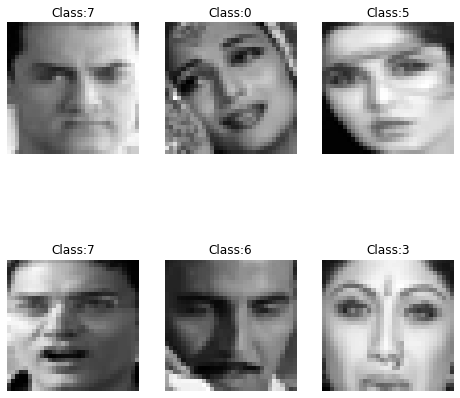

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [7]:
dirpath = './dataset/IIIT-CFW/'
X_1,y_1 = load_data(dirpath)
N_1,H_1,W_1 = X_1.shape[0:3]
C = 1 if opt['is_grayscale'] else X_1.shape[3]

Dataset shape: (672, 32, 32)


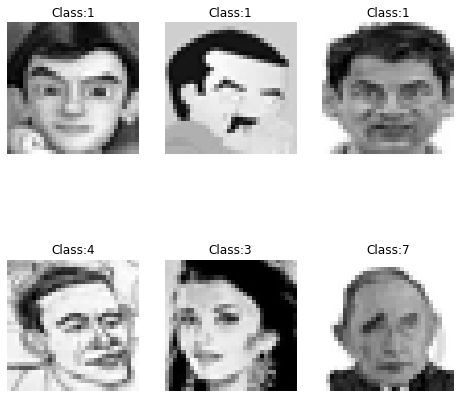

In [8]:
# Show sample images
ind = np.random.randint(0,y_1.shape[0],6)
disply_images(X_1[ind,...],y_1[ind], row=2,col=3)

In [9]:
dirpath = './dataset/Yale_face_database/'
X_2,y_2 = load_data(dirpath)
N_2,H_2,W_2 = X_2.shape[0:3]
C = 1 if opt['is_grayscale'] else X_2.shape[3]

Dataset shape: (165, 32, 32)


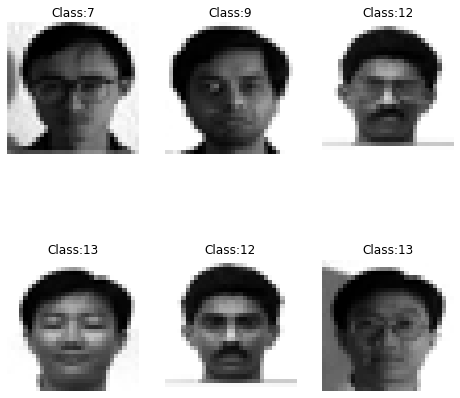

In [10]:
# Show sample images
ind = np.random.randint(0,y_2.shape[0],6)
disply_images(X_2[ind,...],y_2[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features


---


In [11]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [12]:
X_1 = X_1.reshape((N_1,H_1*W_1*C))

In [13]:
X_2 = X_2.reshape((N_2,H_2*W_2*C))

### Custom functions 

In [14]:
def plot_features(X, X_k, y, variance=None):
    """Plot feature distribution and cumulative variance curve"""
    plt.figure(figsize=(16,4)); plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', len(Counter(y))))
    plt.xlabel('Component 1'); plt.ylabel('Component 2')
    plt.title('Input'); 

    plt.subplot(1, 3, 2)
    plt.scatter(X_k[:, 0], X_k[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', len(Counter(y))))
    plt.xlabel('Component 1'); plt.ylabel('Component 2')
    plt.title('Principal Components')
    plt.colorbar(); plt.tight_layout();
    
    if variance is not None:
        plt.subplot(1, 3, 3); plt.plot(variance)
        plt.axhline(y=90, color='k', linestyle='--')
        plt.ylabel("Cumulative % of Variance"); plt.xlabel("No. of Components")
    
def plot_faces(eigenfaces):
    """Visualise Eigenfaces"""
    if eigenfaces.shape[0] <= 10:
        n1, n2 = 1, eigenfaces.shape[0]
    else:
        n1, n2 = 3, 8
    fig, axes = plt.subplots(n1, n2, figsize=(10, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(eigenfaces[i], cmap='bone')

def grid_search(param, X, y):
    """Grid Search for SVM"""
    svm = SVC(random_state=42)
    clf = GridSearchCV(svm, param, cv=10, n_jobs=4, verbose=1)
    clf.fit(X, y)
    print(clf.best_params_)
    
param = [{"kernel": ["linear", "rbf", "poly", "sigmoid"],
          "C": [1, 10, 100, 1000],
          "degree": [1, 3, 5, 10],
          "gamma": [1e-2, 1e-3, 1e-4, 1e-5] }]

In [15]:
""" 
Custom SVM class for 'rbf', 'poly', 'sigmoid' and 'linear' kernels
Data is normalized using StandardScaler()
Reports mean accuracy and weighted F1 score using StratifiedKFold() validation
If required, prints classification_report() and confusion_matrix()
"""

class SVM:
    def __init__(self, degree=3, C=1, gamma=1, splits=5):
        self.rbf_svc = SVC(kernel='rbf', gamma=gamma, C=C, random_state=42)
        self.poly_svc = SVC(kernel='poly', degree=degree, C=C, random_state=42)
        self.lin_svc = LinearSVC(C=C, fit_intercept=False, random_state=42)
        self.sig_svc = SVC(kernel='sigmoid', gamma=gamma, C=C, random_state=42)
        self.cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
        self.models = [self.rbf_svc, self.poly_svc, self.lin_svc, self.sig_svc]
    
    def cross_val(self, clf, X, y):
        scores = []
        for i, (train, test) in enumerate(self.cv.split(X, y)):
            scaler = StandardScaler().fit(X[train])
            X_train = scaler.transform(X[train])
            X_test = scaler.transform(X[test])
            
            clf.fit(X_train, y[train])
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y[test], y_pred)*100
            f1 = f1_score(y[test], y_pred, average='weighted')
            scores.append([acc, f1])
        scores.sort(key=lambda x: x[1])
        return np.array(scores)
    
    def train_final_model(self, clf, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, stratify=y, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        clf.fit(X_train, y_train)
        return clf, X_test, y_test
        
    def train(self, X, y, plot_cm=False):
        scores = {}
        for clf in self.models:
            sc = self.cross_val(clf, X, y)
            print("{} --->  Mean Accuracy: {:.2f}% | Mean F1: {:.2f}".format(
                clf, np.mean(sc[:, 0]), np.mean(sc[:, 1])))
            scores[clf] = np.mean(sc[:, 1])
            
        clf, X_test, y_test = self.train_final_model(max(scores, key=scores.get), X, y)
        self.print_results(clf, X_test, y_test, plot_cm=plot_cm)
        
    def print_results(self, clf, X_test, y_test, plot_cm=False):
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)*100
        f1 = f1_score(y_test, y_pred, average='weighted')
        print("\n{} --->  Best Accuracy: {:.2f}% | Best F1: {:.2f}".format(
                clf, acc, f1))
        if plot_cm:
            print(classification_report(y_test, y_pred))
            print("\nConfusion Matrix for best model:")
            plot_confusion_matrix(clf, X_test, y_test)
            plt.show()

-----------------------------------------------IMFDB------------------------------------------------
SVC(C=3, gamma=0.001, random_state=42) --->  Mean Accuracy: 78.50% | Mean F1: 0.78
SVC(C=3, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 75.50% | Mean F1: 0.75
LinearSVC(C=3, fit_intercept=False, random_state=42) --->  Mean Accuracy: 55.75% | Mean F1: 0.53
SVC(C=3, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 64.75% | Mean F1: 0.64

SVC(C=3, gamma=0.001, random_state=42) --->  Best Accuracy: 88.75% | Best F1: 0.89
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.75      0.90      0.82        10
           2       0.90      0.90      0.90        10
           3       0.88      0.70      0.78        10
           4       0.91      1.00      0.95        10
           5       1.00      0.90      0.95        10
           6       1.00      0.80      0.89        10
      

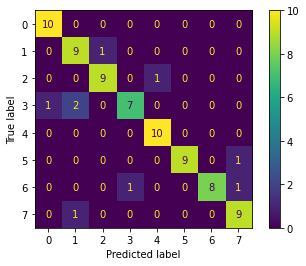

----------------------------------------------IIIT-CFW----------------------------------------------
SVC(C=3, gamma=0.001, random_state=42) --->  Mean Accuracy: 56.85% | Mean F1: 0.57
SVC(C=3, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 54.49% | Mean F1: 0.54
LinearSVC(C=3, fit_intercept=False, random_state=42) --->  Mean Accuracy: 28.58% | Mean F1: 0.29
SVC(C=3, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 35.00% | Mean F1: 0.35

SVC(C=3, gamma=0.001, random_state=42) --->  Best Accuracy: 57.78% | Best F1: 0.58
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.80      0.44      0.57         9
           2       0.40      0.38      0.39        16
           3       0.52      0.70      0.60        20
           4       0.75      0.45      0.56        20
           5       0.60      0.75      0.67        20
           6       0.50      0.65      0.57        20
      

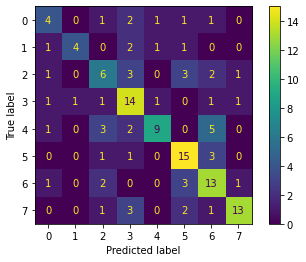

------------------------------------------------Yale------------------------------------------------
SVC(C=3, gamma=0.001, random_state=42) --->  Mean Accuracy: 81.84% | Mean F1: 0.78
SVC(C=3, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 92.17% | Mean F1: 0.90
LinearSVC(C=3, fit_intercept=False, random_state=42) --->  Mean Accuracy: 100.00% | Mean F1: 1.00
SVC(C=3, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 88.46% | Mean F1: 0.86

LinearSVC(C=3, fit_intercept=False, random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00 

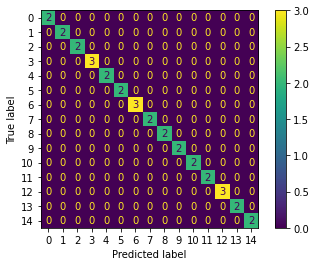

In [16]:
# Performance on raw dataset 
print("IMFDB".center(100, "-"))
svm = SVM(degree=1, C=3, gamma=0.001, splits=10)
svm.train(X, y, True)

print("IIIT-CFW".center(100, "-"))
svm_1 = SVM(degree=1, C=3, gamma=0.001, splits=10)
svm_1.train(X_1, y_1, True)

print("Yale".center(100, "-")) 
svm_2 = SVM(degree=1, C=3, gamma=0.001, splits=10)
svm_2.train(X_2, y_2, True)

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [17]:
def get_pca(X, k):
    """
        Get PCA of K dimension using the top eigenvectors 
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components=k, svd_solver='randomized', random_state=42, whiten=True).fit(X)
    X_k = pca.transform(X)
    eigenfaces = pca.components_.reshape((k, opt['image_size'], opt['image_size']))
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
    return X_k, eigenfaces, variance

(400, 100) (400,) (100, 32, 32)
SVC(C=3, gamma=0.01, random_state=42) --->  Mean Accuracy: 79.75% | Mean F1: 0.79
SVC(C=3, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 73.25% | Mean F1: 0.73
LinearSVC(C=3, fit_intercept=False, random_state=42) --->  Mean Accuracy: 72.00% | Mean F1: 0.70
SVC(C=3, gamma=0.01, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 73.25% | Mean F1: 0.73

SVC(C=3, gamma=0.01, random_state=42) --->  Best Accuracy: 78.75% | Best F1: 0.79
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.71      0.50      0.59        10
           2       0.90      0.90      0.90        10
           3       0.89      0.80      0.84        10
           4       0.67      0.80      0.73        10
           5       1.00      0.80      0.89        10
           6       0.80      0.80      0.80        10
           7       0.58      0.70      0.64        10

    accuracy           

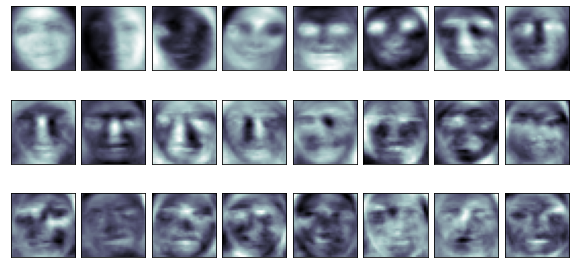

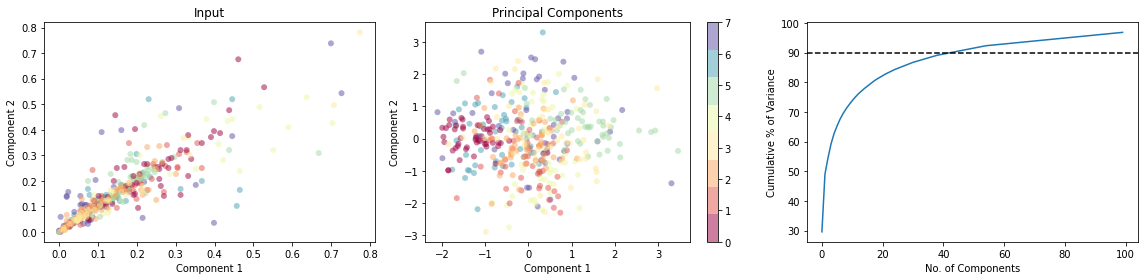

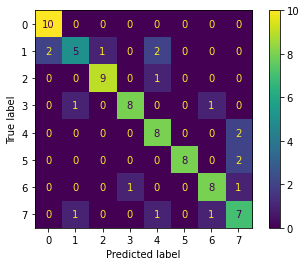

In [18]:
X_pca, eigenfaces, cvar = get_pca(X, 100)
print(X_pca.shape, y.shape, eigenfaces.shape)

plot_faces(eigenfaces)
plot_features(X, X_pca, y, cvar)

svm_pca = SVM(degree=1, C=3, gamma=0.01, splits=10)
svm_pca.train(X_pca[:, :40], y, True)

(672, 100) (672,) (100, 32, 32)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 52.09% | Mean F1: 0.51
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 49.69% | Mean F1: 0.49
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 43.01% | Mean F1: 0.43
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 50.60% | Mean F1: 0.49

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 51.11% | Best F1: 0.50
              precision    recall  f1-score   support

           0       0.20      0.10      0.13        10
           1       0.50      0.33      0.40         9
           2       0.36      0.31      0.33        16
           3       0.56      0.50      0.53        20
           4       0.45      0.45      0.45        20
           5       0.59      0.65      0.62        20
           6       0.67      0.80      0.73        20
           7       0.46      0.60      0.52        20

    accuracy   

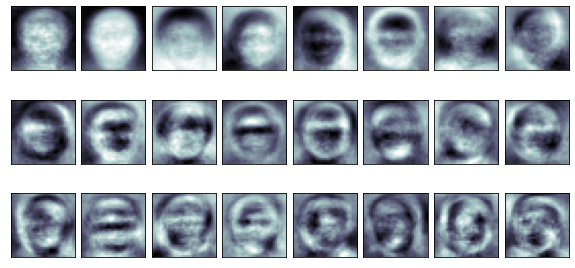

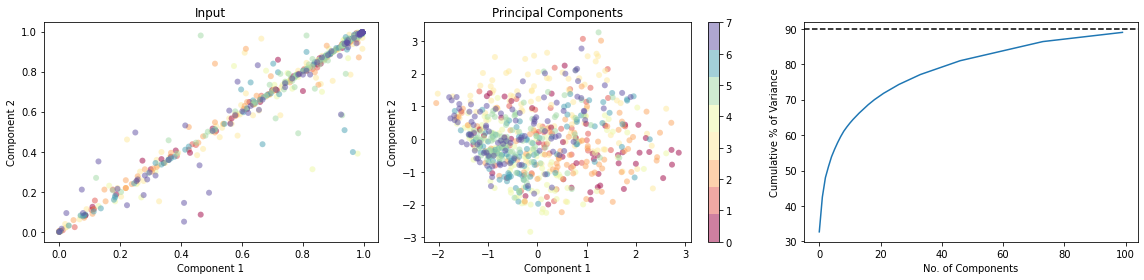

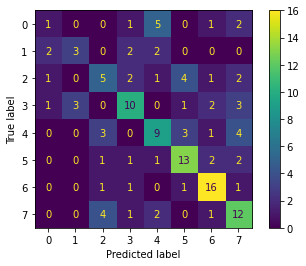

In [19]:
X_pca_1, eigenfaces_1, cvar_1 = get_pca(X_1, 100)
print(X_pca_1.shape, y_1.shape, eigenfaces_1.shape)

plot_faces(eigenfaces_1)
plot_features(X_1, X_pca_1, y_1, cvar_1)

svm_pca_1 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_pca_1.train(X_pca_1[:, :40], y_1, True)

(165, 100) (165,) (100, 32, 32)
SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 96.91% | Mean F1: 0.96
SVC(C=5, degree=5, kernel='poly', random_state=42) --->  Mean Accuracy: 63.64% | Mean F1: 0.59
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 99.38% | Mean F1: 0.99
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 93.93% | Mean F1: 0.94

LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Best Accuracy: 96.97% | Best F1: 0.97
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         2
       

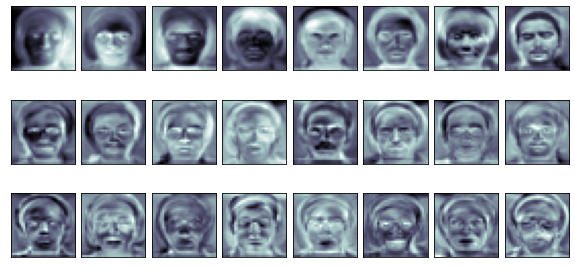

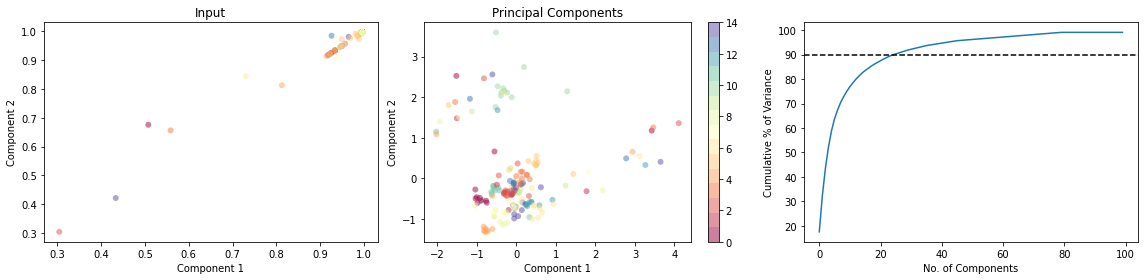

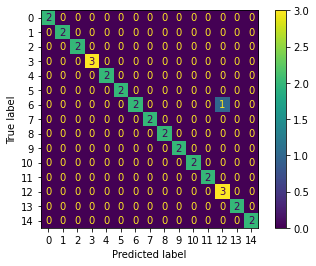

In [20]:
X_pca_2, eigenfaces_2, cvar_2 = get_pca(X_2, 100)
print(X_pca_2.shape, y_2.shape, eigenfaces_2.shape)

plot_faces(eigenfaces_2)
plot_features(X_2, X_pca_2, y_2, cvar_2)

svm_pca_2 = SVM(degree=5, C=5, gamma=0.001, splits=10)
svm_pca_2.train(X_pca_2[:, :30], y_2, True)
# plt.savefig("cm3.png", dpi=150, bbox_inches='tight')

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [21]:
def get_kernel_pca(X, k, kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    kpca = KernelPCA(kernel=kernel, degree=degree, n_components=k, n_jobs=-1,
                     fit_inverse_transform=True, random_state=42)
    X_k = kpca.fit_transform(X)
    # eigenvectors = kpca.alphas_.reshape((k, opt['image_size'], opt['image_size']))
    exp_var = np.var(X_k, axis=0)
    exp_var_ratio = (exp_var / np.sum(exp_var))*100
    variance = np.cumsum(exp_var_ratio)
    return X_k, variance 

(400, 100) (400,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 75.75% | Mean F1: 0.75
SVC(C=10, degree=5, kernel='poly', random_state=42) --->  Mean Accuracy: 32.25% | Mean F1: 0.31
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 68.00% | Mean F1: 0.67
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 73.00% | Mean F1: 0.72

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 78.75% | Best F1: 0.78
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.62      0.80      0.70        10
           2       0.90      0.90      0.90        10
           3       0.67      0.40      0.50        10
           4       1.00      0.90      0.95        10
           5       0.80      0.80      0.80        10
           6       0.89      0.80      0.84        10
           7       0.58      0.70      0.64        10

    accuracy                 

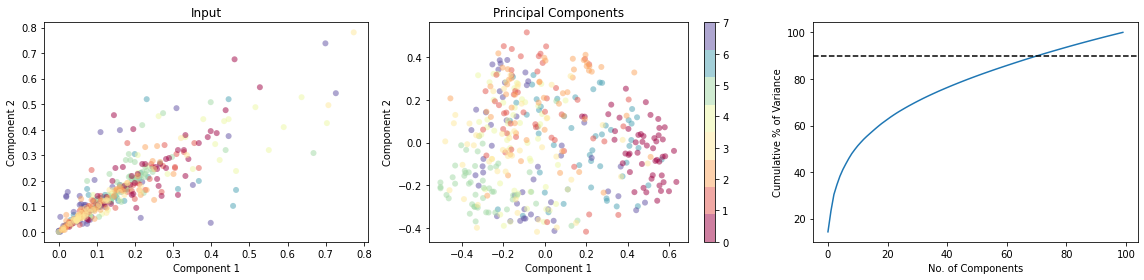

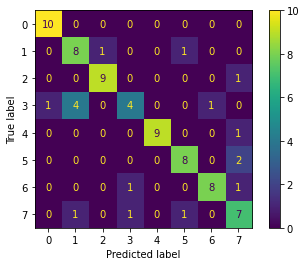

In [22]:
X_kpca, cvar = get_kernel_pca(X, 100, "rbf", 3)
print(X_kpca.shape, y.shape)

plot_features(X, X_kpca, y, cvar)

svm_kpca = SVM(degree=5, C=10, gamma=0.001, splits=10)
svm_kpca.train(X_kpca[:, :60], y, True)

(672, 100) (672,)
SVC(C=100, gamma=0.01, random_state=42) --->  Mean Accuracy: 56.11% | Mean F1: 0.56
SVC(C=100, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 43.75% | Mean F1: 0.44
LinearSVC(C=100, fit_intercept=False, random_state=42) --->  Mean Accuracy: 32.46% | Mean F1: 0.32
SVC(C=100, gamma=0.01, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 44.92% | Mean F1: 0.45

SVC(C=100, gamma=0.01, random_state=42) --->  Best Accuracy: 54.07% | Best F1: 0.54
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.44      0.44      0.44         9
           2       0.35      0.38      0.36        16
           3       0.45      0.50      0.48        20
           4       0.67      0.40      0.50        20
           5       0.59      0.80      0.68        20
           6       0.61      0.70      0.65        20
           7       0.67      0.50      0.57        20

    accuracy               

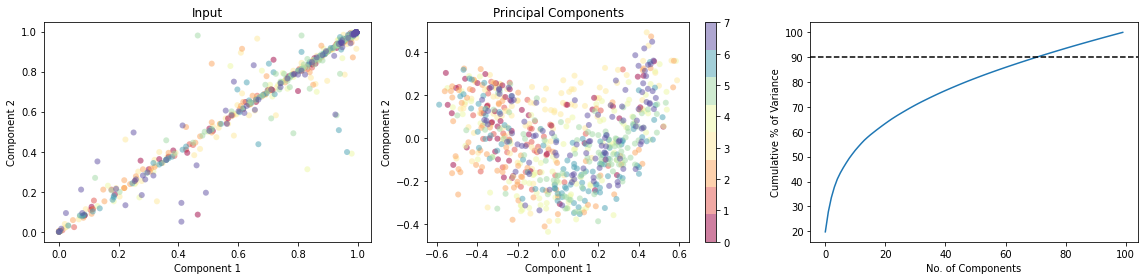

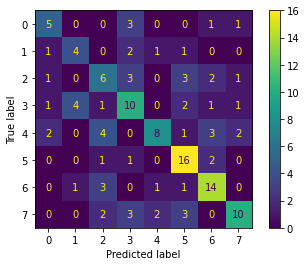

In [23]:
X_kpca_1, cvar_1 = get_kernel_pca(X_1, 100, "rbf", 3)
print(X_kpca_1.shape, y_1.shape)

plot_features(X_1, X_kpca_1, y_1, cvar_1)

svm_kpca_1 = SVM(degree=1, C=100, gamma=0.01, splits=10)
svm_kpca_1.train(X_kpca_1[:, :60], y_1, True)

(165, 100) (165,)
SVC(C=1, gamma=0.01, random_state=42) --->  Mean Accuracy: 78.13% | Mean F1: 0.73
SVC(C=1, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 79.93% | Mean F1: 0.75
LinearSVC(C=1, fit_intercept=False, random_state=42) --->  Mean Accuracy: 92.68% | Mean F1: 0.91
SVC(C=1, gamma=0.01, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 78.71% | Mean F1: 0.74

LinearSVC(C=1, fit_intercept=False, random_state=42) --->  Best Accuracy: 90.91% | Best F1: 0.90
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.75      1.00      0.86         3
           4       1.00      0.50      0.67         2
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00

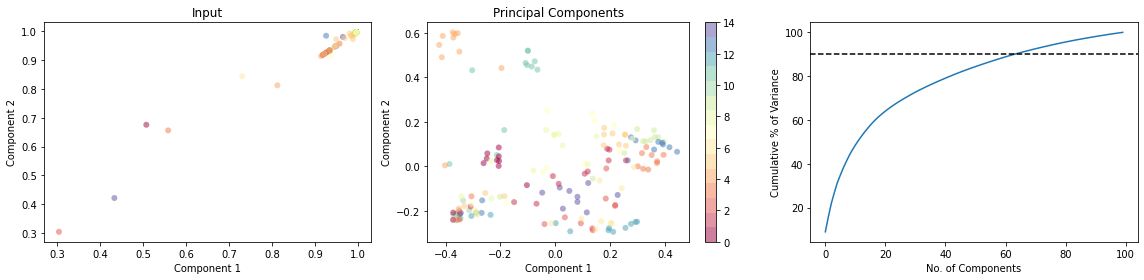

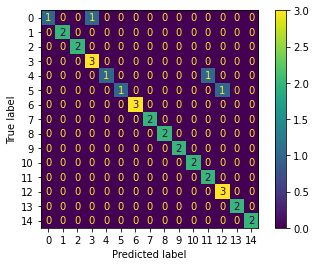

In [24]:
X_kpca_2, cvar_2 = get_kernel_pca(X_2, 100, "rbf", 3)
print(X_kpca_2.shape, y_2.shape)

plot_features(X_2, X_kpca_2, y_2, cvar_2)

svm_kpca_2 = SVM(degree=1, C=1, gamma=0.01, splits=10)
svm_kpca_2.train(X_kpca_2[:, :40], y_2, True)

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.


Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [25]:
def get_lda(X, y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components=k, svd_solver='randomized', random_state=42, whiten=True).fit(X)
    X_pca = pca.transform(X)
    lda = LDA().fit(X_pca, y)
    X_l = lda.transform(X_pca)
    eigenfaces = []
    for i in range(lda.scalings_.shape[-1]):
        eigenfaces.append(pca.inverse_transform(lda.scalings_[:, i]).reshape((opt['image_size'], opt['image_size'])))
    variance = np.cumsum(np.round(lda.explained_variance_ratio_, decimals=3)*100)
    return X_l, np.array(eigenfaces), variance

(400, 7) (400,) (7, 32, 32)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 83.00% | Mean F1: 0.82
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 80.50% | Mean F1: 0.80
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 82.00% | Mean F1: 0.81
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 82.75% | Mean F1: 0.82

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 86.25% | Best F1: 0.86
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.88      0.70      0.78        10
           2       0.82      0.90      0.86        10
           3       0.90      0.90      0.90        10
           4       0.90      0.90      0.90        10
           5       1.00      0.90      0.95        10
           6       0.89      0.80      0.84        10
           7       1.00      0.80      0.89        10

    accuracy       

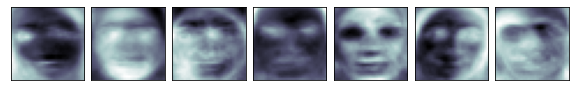

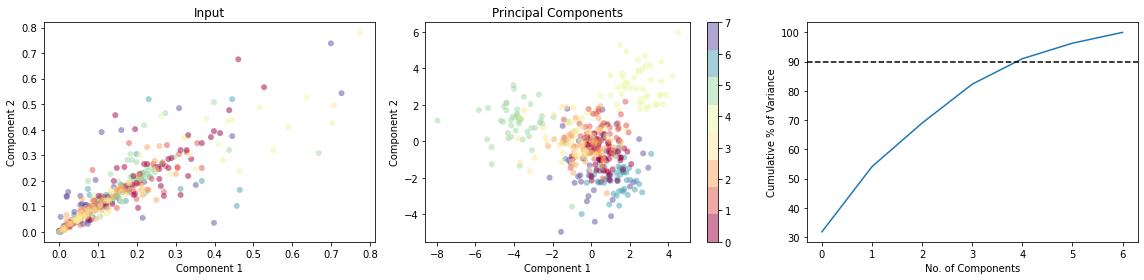

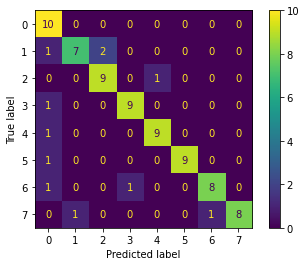

In [26]:
X_flda, eigenfaces, cvar = get_lda(X, y, 50)
print(X_flda.shape, y.shape, eigenfaces.shape)

plot_faces(eigenfaces)    
plot_features(X, X_flda, y, cvar)

# grid_search(param, X_lda[:, :20], y)
svm_flda = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_flda.train(X_flda[:, :6], y, True)

(672, 7) (672,) (7, 32, 32)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 61.91% | Mean F1: 0.61
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 60.27% | Mean F1: 0.60
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 61.61% | Mean F1: 0.61
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 61.61% | Mean F1: 0.60

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 60.00% | Best F1: 0.58
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.60      0.33      0.43         9
           2       0.50      0.38      0.43        16
           3       0.57      0.65      0.60        20
           4       0.77      0.50      0.61        20
           5       0.58      0.75      0.65        20
           6       0.55      0.80      0.65        20
           7       0.73      0.80      0.76        20

    accuracy       

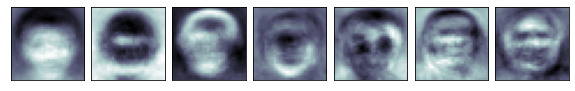

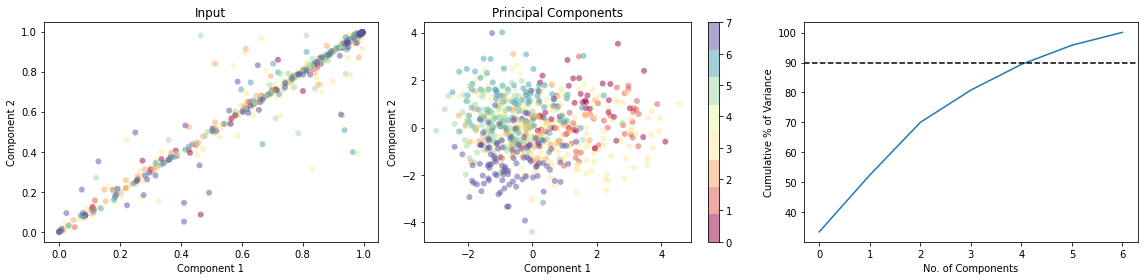

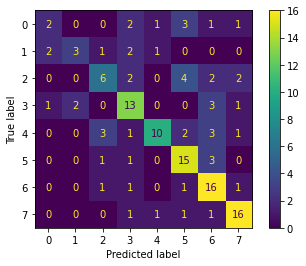

In [27]:
X_flda_1, eigenfaces_1, cvar_1 = get_lda(X_1, y_1, 50)
print(X_flda_1.shape, y_1.shape, eigenfaces_1.shape)

plot_faces(eigenfaces_1)
plot_features(X_1, X_flda_1, y_1, cvar_1)

# grid_search(param, X_lda_1[:, :10], y_1)
svm_flda_1 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_flda_1.train(X_flda_1[:, :8], y_1, True)

(165, 14) (165,) (14, 32, 32)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 95.29% | Mean F1: 0.94
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 100.00% | Mean F1: 1.00
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 92.72% | Mean F1: 0.90
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 86.18% | Mean F1: 0.82

SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
    

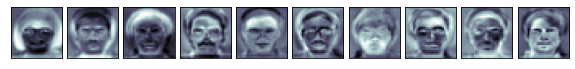

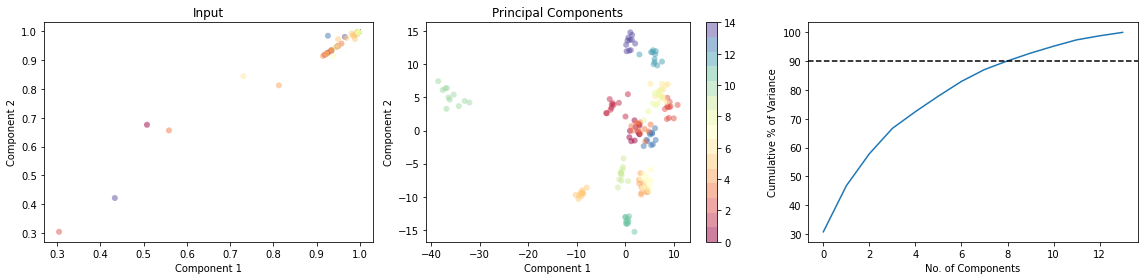

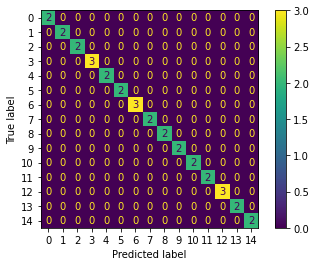

In [28]:
X_flda_2, eigenfaces_2, cvar_2 = get_lda(X_2, y_2, 50)
print(X_flda_2.shape, y_2.shape, eigenfaces_2.shape)

plot_faces(eigenfaces_2[:10, :, :])
plot_features(X_2, X_flda_2, y_2, cvar_2)

# grid_search(param, X_lda_1[:, :10], y_1)
svm_flda_2 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_flda_2.train(X_flda_2[:, :8], y_2, True)

### 3.1 Vanilla LDA

In [29]:
def get_lda_vanilla(X, y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    lda = LDA().fit(X, y)
    X_l = lda.transform(X)
    variance = np.cumsum(np.round(lda.explained_variance_ratio_, decimals=3)*100)
    return X_l, variance

(400, 7) (400,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 96.25% | Mean F1: 0.96
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 95.75% | Mean F1: 0.96
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 82.00% | Mean F1: 0.77
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 96.50% | Mean F1: 0.96

SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10

    accuracy

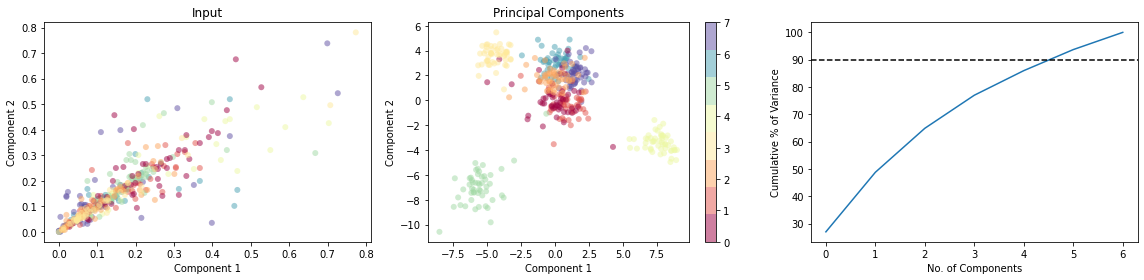

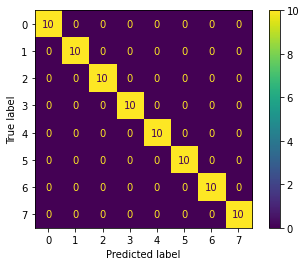

In [30]:
X_lda, cvar = get_lda_vanilla(X, y, 50)
print(X_lda.shape, y.shape)
    
plot_features(X, X_lda, y, cvar)

# grid_search(param, X_lda[:, :10], y)
svm_lda = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_lda.train(X_lda[:, :5], y, True)

(672, 7) (672,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 96.88% | Mean F1: 0.97
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 96.13% | Mean F1: 0.96
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 94.95% | Mean F1: 0.95
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 97.03% | Mean F1: 0.97

SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Best Accuracy: 97.78% | Best F1: 0.98
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00         9
           2       0.93      0.88      0.90        16
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       0.91      1.00      0.95        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20

    accuracy 

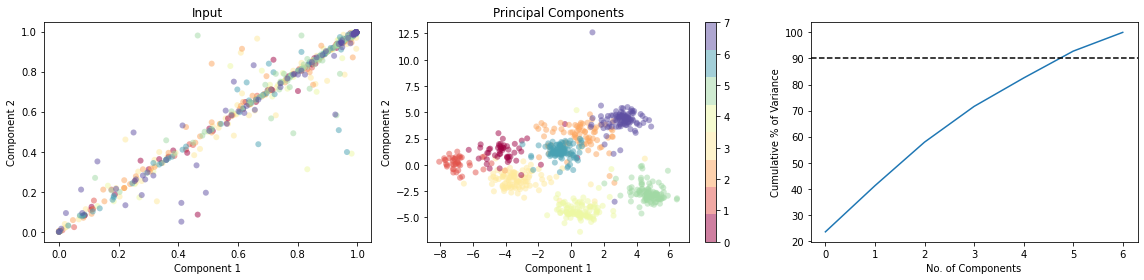

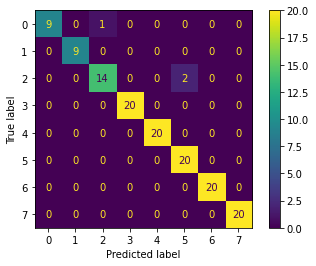

In [31]:
X_lda_1, cvar_1 = get_lda_vanilla(X_1, y_1, 50)
print(X_lda_1.shape, y_1.shape)
    
plot_features(X_1, X_lda_1, y_1, cvar_1)

# grid_search(param, X_lda_1[:, :10], y_1)
svm_lda_1 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_lda_1.train(X_lda_1[:, :5], y_1, True)

(165, 14) (165,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 95.15% | Mean F1: 0.94
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 100.00% | Mean F1: 1.00
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 95.81% | Mean F1: 0.94
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 86.76% | Mean F1: 0.83

SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8     

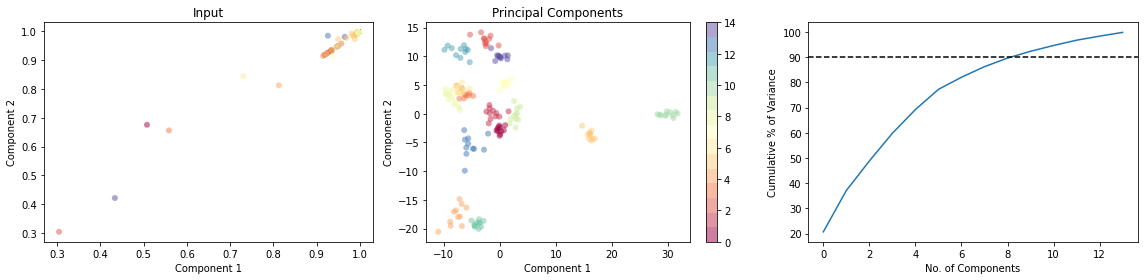

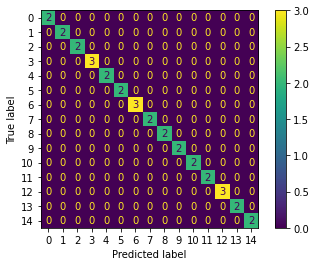

In [32]:
X_lda_2, cvar_2 = get_lda_vanilla(X_2, y_2, 50)
print(X_lda_2.shape, y_2.shape)

plot_features(X_2, X_lda_2, y_2, cvar_2)

# grid_search(param, X_lda_2[:, :10], y_2)
svm_lda_2 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_lda_2.train(X_lda_2[:, :8], y_2, True)

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [33]:
def get_kernel_lda(X, y, k, kernel='rbf', degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    kpca = KernelPCA(kernel=kernel, degree=degree, n_components=k, n_jobs=-1,
                     fit_inverse_transform=True, random_state=42)
    X_kpca = kpca.fit_transform(X)
    lda = LDA().fit(X_kpca, y)
    X_l = lda.transform(X_kpca)
    variance = np.cumsum(np.round(lda.explained_variance_ratio_, decimals=3)*100)
    return X_l, variance

(400, 7) (400,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 79.75% | Mean F1: 0.79
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 79.00% | Mean F1: 0.79
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 70.75% | Mean F1: 0.65
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 79.00% | Mean F1: 0.79

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 85.00% | Best F1: 0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.67      0.60      0.63        10
           2       0.69      0.90      0.78        10
           3       1.00      0.70      0.82        10
           4       0.90      0.90      0.90        10
           5       1.00      0.90      0.95        10
           6       1.00      0.80      0.89        10
           7       0.71      1.00      0.83        10

    accuracy                   

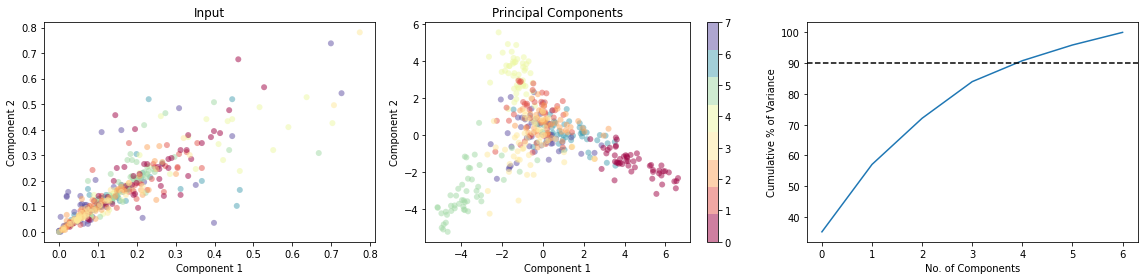

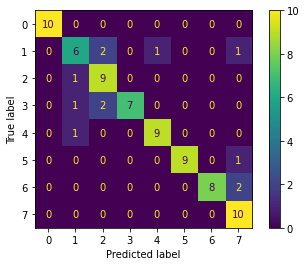

In [34]:
X_klda, cvar = get_kernel_lda(X, y, 50, 'rbf', 1)
print(X_klda.shape, y.shape)
    
plot_features(X, X_klda, y, cvar)

# grid_search(param, X_klda[:, :10], y)
svm_klda = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_klda.train(X_klda[:, :5], y, True)

(672, 7) (672,)
SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 62.23% | Mean F1: 0.62
SVC(C=10, degree=5, kernel='poly', random_state=42) --->  Mean Accuracy: 51.34% | Mean F1: 0.51
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 60.29% | Mean F1: 0.59
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 58.96% | Mean F1: 0.56

SVC(C=10, gamma=0.001, random_state=42) --->  Best Accuracy: 60.74% | Best F1: 0.60
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.80      0.44      0.57         9
           2       0.45      0.31      0.37        16
           3       0.55      0.80      0.65        20
           4       0.56      0.50      0.53        20
           5       0.55      0.60      0.57        20
           6       0.60      0.75      0.67        20
           7       0.75      0.75      0.75        20

    accuracy                   

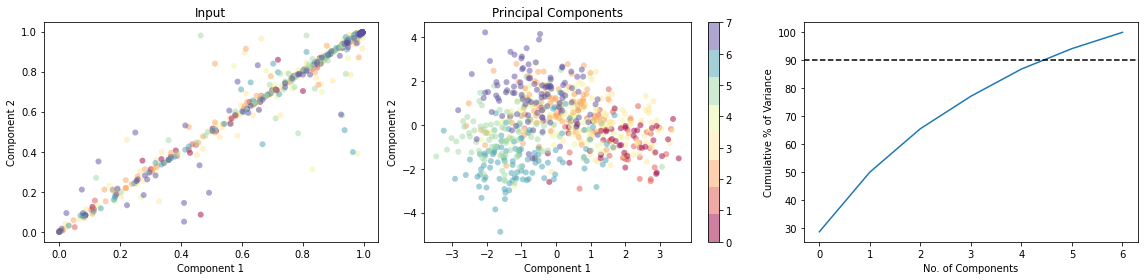

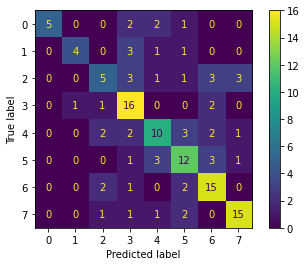

In [35]:
X_klda_1, cvar_1 = get_kernel_lda(X_1, y_1, 50, 'rbf', 1)
print(X_klda_1.shape, y_1.shape)
    
plot_features(X_1, X_klda_1, y_1, cvar_1)

# grid_search(param, X_klda_1[:, :10], y_1)
svm_klda_1 = SVM(degree=5, C=10, gamma=0.001, splits=10)
svm_klda_1.train(X_klda_1[:, :5], y_1, True)

(165, 14) (165,)
SVC(C=10, gamma=0.01, random_state=42) --->  Mean Accuracy: 99.38% | Mean F1: 0.99
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 98.75% | Mean F1: 0.98
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 70.88% | Mean F1: 0.62
SVC(C=10, gamma=0.01, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 98.75% | Mean F1: 0.98

SVC(C=10, gamma=0.01, random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00

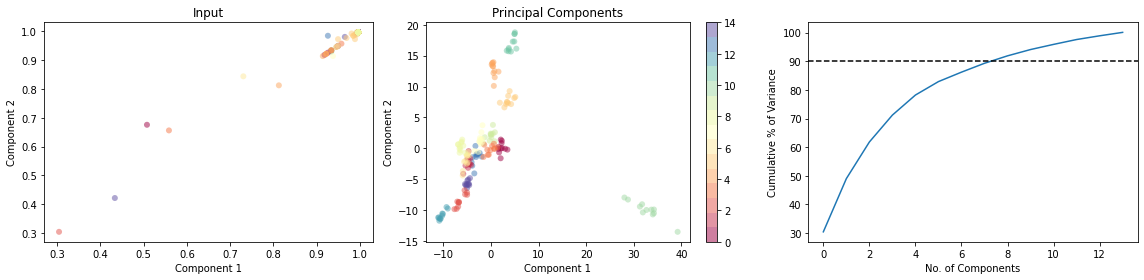

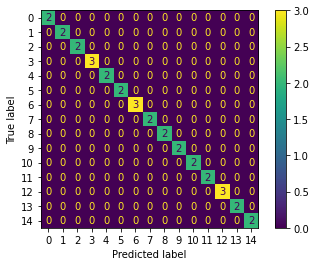

In [36]:
X_klda_2, cvar_2 = get_kernel_lda(X_2, y_2, 50, 'rbf', 1)
print(X_klda_2.shape, y_2.shape)
    
plot_features(X_2, X_klda_2, y_2, cvar_2)

# grid_search(param, X_klda_2[:, :10], y_2)
svm_klda_2 = SVM(degree=1, C=10, gamma=0.01, splits=10)
svm_klda_2.train(X_klda_2[:, :7], y_2, True)

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.


In [37]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath, "VGG19_features.npy"))
    return features

SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 87.25% | Mean F1: 0.87
SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 90.00% | Mean F1: 0.90
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 86.75% | Mean F1: 0.87
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 86.50% | Mean F1: 0.86

SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Best Accuracy: 88.75% | Best F1: 0.89
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.70      0.70      0.70        10
           2       0.90      0.90      0.90        10
           3       0.89      0.80      0.84        10
           4       1.00      1.00      1.00        10
           5       0.91      1.00      0.95        10
           6       0.89      0.80      0.84        10
           7       0.90      0.90      0.90        10

    accuracy                           0

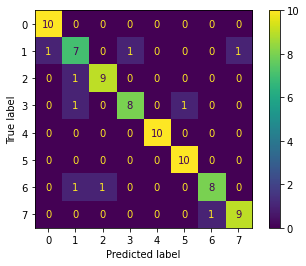

In [38]:
X_vgg = get_vgg_features('./dataset/IMFDB/')

svm_vgg = SVM(degree=1, C=5, gamma=0.001, splits=10)
svm_vgg.train(X_vgg, y, True)

SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 67.14% | Mean F1: 0.66
SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 70.56% | Mean F1: 0.70
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 64.46% | Mean F1: 0.64
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 59.25% | Mean F1: 0.58

SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Best Accuracy: 71.85% | Best F1: 0.72
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        10
           1       0.86      0.67      0.75         9
           2       0.75      0.56      0.64        16
           3       0.94      0.80      0.86        20
           4       0.46      0.55      0.50        20
           5       0.85      0.85      0.85        20
           6       0.82      0.70      0.76        20
           7       0.71      0.85      0.77        20

    accuracy                           0

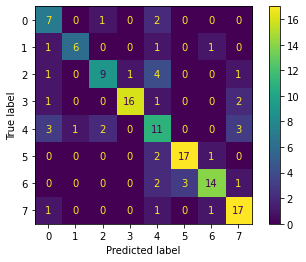

In [39]:
X_vgg_1 = get_vgg_features('./dataset/IIIT-CFW/')

svm_vgg_1 = SVM(degree=1, C=5, gamma=0.001, splits=10)
svm_vgg_1.train(X_vgg_1, y_1, True)

SVC(C=10, gamma=0.001, random_state=42) --->  Mean Accuracy: 55.26% | Mean F1: 0.50
SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 58.90% | Mean F1: 0.54
LinearSVC(C=10, fit_intercept=False, random_state=42) --->  Mean Accuracy: 57.65% | Mean F1: 0.52
SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 40.55% | Mean F1: 0.36

SVC(C=10, degree=1, kernel='poly', random_state=42) --->  Best Accuracy: 69.70% | Best F1: 0.63
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.33      1.00      0.50         2
           3       1.00      1.00      1.00         3
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         2
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         2
           8       0.00      0.00   

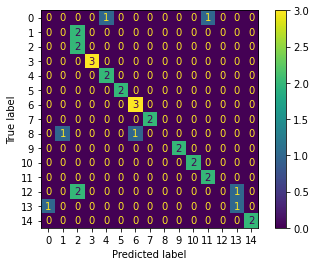

In [40]:
X_vgg_2 = get_vgg_features('./dataset/Yale_face_database/')

svm_vgg_2 = SVM(degree=1, C=10, gamma=0.001, splits=10)
svm_vgg_2.train(X_vgg_2, y_2, True) 

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 



In [41]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath, "resnet50_features.npy"))
    return features

SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 95.25% | Mean F1: 0.95
SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 96.00% | Mean F1: 0.96
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 96.00% | Mean F1: 0.96
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 95.50% | Mean F1: 0.95

LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Best Accuracy: 98.75% | Best F1: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       0.91      1.00      0.95        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10

    accuracy                          

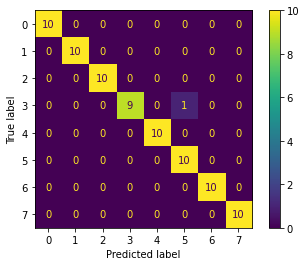

In [42]:
X_res = get_resnet_features('./dataset/IMFDB/')

svm_res = SVM(degree=1, C=5, gamma=0.001, splits=10)
svm_res.train(X_res, y, True)

SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 97.02% | Mean F1: 0.97
SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 96.87% | Mean F1: 0.97
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 96.87% | Mean F1: 0.97
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 96.72% | Mean F1: 0.97

SVC(C=5, gamma=0.001, random_state=42) --->  Best Accuracy: 97.78% | Best F1: 0.98
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        16
           3       0.95      1.00      0.98        20
           4       1.00      0.95      0.97        20
           5       1.00      0.95      0.97        20
           6       1.00      1.00      1.00        20
           7       0.95      0.95      0.95        20

    accuracy                           0.98       13

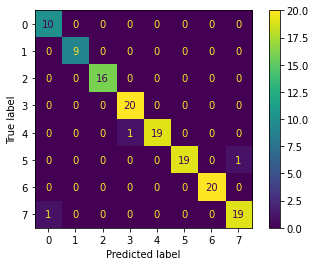

In [43]:
X_res_1 = get_resnet_features('./dataset/IIIT-CFW/')

svm_res_1 = SVM(degree=1, C=5, gamma=0.001, splits=10)
svm_res_1.train(X_res_1, y_1, True)

SVC(C=5, gamma=0.001, random_state=42) --->  Mean Accuracy: 98.75% | Mean F1: 0.98
SVC(C=5, degree=1, kernel='poly', random_state=42) --->  Mean Accuracy: 98.75% | Mean F1: 0.98
LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Mean Accuracy: 99.38% | Mean F1: 0.99
SVC(C=5, gamma=0.001, kernel='sigmoid', random_state=42) --->  Mean Accuracy: 99.38% | Mean F1: 0.99

LinearSVC(C=5, fit_intercept=False, random_state=42) --->  Best Accuracy: 100.00% | Best F1: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00     

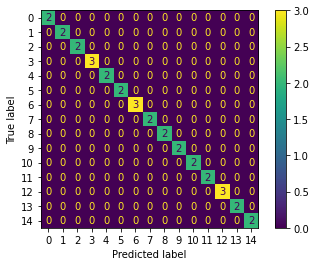

In [44]:
X_res_2 = get_resnet_features('./dataset/Yale_face_database')

svm_res_2 = SVM(degree=1, C=5, gamma=0.001, splits=10)
svm_res_2.train(X_res_2, y_2, True)

# Questions

### 1(a). What are Eigenfaces? 
> Eigenfaces are nothing but the eigenvectors obtained from PCA when used for human face recognition. Since images are high dimensional data, we need components which capture most variability in the dataset. Thus, all faces in the dataset can be represented as linear combinations of these eigenfaces. The information loss is inversely related to the number of top k eigenfaces we select.

### 1(b). How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.

> Using eigenvectors which capture around 90\% of the total variance worked best to "satisfactorily' reconstruct faces. For IMFDB, first 40 eigenvectors are taken, 40 for IIIT-CFW, and 30 for Yale Dataset. The corresponding graphs are given below the `get_pca()` cell [here](#1.-Eigen-Face:).

### 1(c). Reconstruct the image back for each case

> First, the data is centered and covariance matrix is calculated. The mean of the dataset is added to the top {\bf k} eigenvectors and these are our final eigenvectors. Now, the dot product of these eigenvectors and Principal Component projections gives us the reconstructed images. Mean Squared Error is chosen to measure reconstruction error. The results are shown in the end. The process can be described as: `Image = PC Projections · Eigenvectors^{T} + Mean`

In [45]:
def reconstruct_images(eigenvectors, X_k):
    """
        Reconstruct the images back by just using the selected principal components. 
        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
        @params: Input parameters
        @return reconstructed_X => reconstructed image
    """ 
    reconstruct_X = np.dot(eigenvectors, X_k.T).T
    return reconstruct_X    

In [46]:
def get_eigenvectors(X, k):
    """Computes covariance matrix and returns top k eigenvectors + mean"""
    X_mean = np.mean(X, axis=0)
    X -= X_mean 
    cov = np.cov(X.T)
    evals, evecs = linalg.eigh(cov)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    X_mean = np.expand_dims(X_mean, axis=-1)
    return evecs[:, :k] + X_mean

def reconstruction_error(X, X_k, k):
    evec = get_eigenvectors(X, k)
    rimg = reconstruct_images(evec, X_k)
    err = mean_squared_error(X, rimg)
    return round(err, 3)

In [54]:
# Reconstruction error for each dataset 
# NOTE: run again if values look weird
print("IMFDB".center(100, "-"))
print("PCA:", reconstruction_error(X, X_pca, 100))
print("KPCA:", reconstruction_error(X, X_kpca, 100))
print("Fisher:", reconstruction_error(X, X_flda, 7))
print("LDA:", reconstruction_error(X, X_lda, 7))
print("KLDA:", reconstruction_error(X, X_klda, 7))

print("IIIT-CFW".center(100, "-"))
print("PCA:", reconstruction_error(X_1, X_pca_1, 100))
print("KPCA:", reconstruction_error(X_1, X_kpca_1, 100))
print("Fisher:", reconstruction_error(X_1, X_flda_1, 7))
print("LDA:", reconstruction_error(X_1, X_lda_1, 7))
print("KLDA:", reconstruction_error(X_1, X_klda_1, 7))

print("Yale".center(100, "-")) 
print("PCA:", reconstruction_error(X_2, X_pca_2, 100))
print("KPCA:", reconstruction_error(X_2, X_kpca_2, 100))
print("Fisher:", reconstruction_error(X_2, X_flda_2, 14))
print("LDA:", reconstruction_error(X_2, X_lda_2, 14))
print("KLDA:", reconstruction_error(X_2, X_klda_2, 14))

-----------------------------------------------IMFDB------------------------------------------------
PCA: 0.113
KPCA: 0.026
Fisher: 0.037
LDA: 0.084
KLDA: 0.038
----------------------------------------------IIIT-CFW----------------------------------------------
PCA: 0.153
KPCA: 0.074
Fisher: 0.081
LDA: 0.13
KLDA: 0.075
------------------------------------------------Yale------------------------------------------------
PCA: 0.157
KPCA: 0.053
Fisher: 0.497
LDA: 0.509
KLDA: 0.277


### 1(d). Which person/identity is difficult to represent compactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

> For IMFDB, performance of eigenfaces from PCA is worst for Kajol. This is due to a combination of complex facial expressions and variations in illumination. 

> For IIIT-CFW, Amitabh Bachan is much harder to represent than others. This might probably be due to complex facial features which require more eigenvectors to represent.

> For Yale, Class 6 is slightly harder to represent.

### 2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. Write code from scratch making Classifer as a class and functions of training, validation and confusion matrix etc.

> The custom `SVM()` class defined previously has 'rbf', 'poly', 'sigmoid' and 'linear' kernels. Data is normalized using `StandardScaler()`. Reports mean accuracy and weighted F1 score using `StratifiedKFold()` validation. If required, prints `classification_report()` and `confusion_matrix()`.

### 2(b). Which method works well? Do a comparitive study. 

> We can see that vanilla LDA works best for our task. PCA reduces dimensions by focusing on the features with the most variation. LDA is like PCA, but it focuses on maximizing the separability among known categories. This leads to better performance for classification tasks. Figure is given in report

### 3.Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? 

> The function and plots are given below. Best discrimination is obtained when vanilla LDA is used with TSNE. There is clear clustering of all the different classes of people in all datasets. The combined dataset is obtained by concatenating all images and we can again see good separation in classes with some reasonable amount of outliers. 

In [48]:
def plot_tsne(X, y, k_lda, k_tsne, title):
    X_l, _ = get_lda_vanilla(X, y, k_lda)
    X_tsne = TSNE(n_components=k_tsne).fit_transform(X_l)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', len(Counter(y))))
    plt.xlabel('Component 1'); plt.ylabel('Component 2')
    plt.title(title); plt.colorbar(); plt.show()

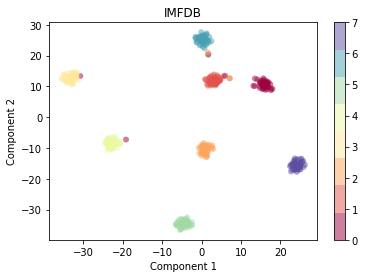

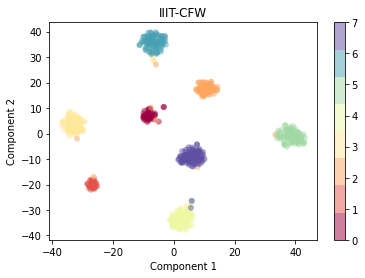

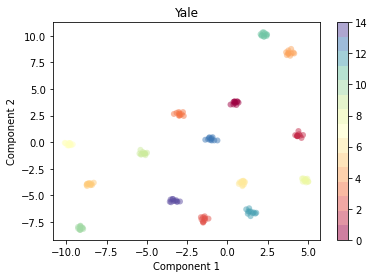

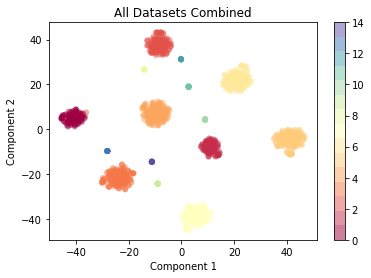

In [49]:
# TSNE plot for each dataset 
plot_tsne(X, y, 50, 2, "IMFDB")

plot_tsne(X_1, y_1, 50, 2, "IIIT-CFW")

plot_tsne(X_2, y_2, 50, 2, "Yale")

X_c = np.concatenate([X, X_1, X_2], axis=0)
y_c = np.concatenate([y, y_1, y_2], axis=0)
plot_tsne(X_c, y_c, 50, 2, "All Datasets Combined")
# plt.savefig("./images/tsne_4.png", dpi=150, bbox_inches='tight')

### 4.`face`  is  used  for  verification.   
### 4(a). How do we formulate the problem using KNN?

> We can extract any one of the above features and calculate K Nearest Neighbors for each testing face. This builds on the assumption that data points of similar classes are closer to each other. I think LDA will be better for this task since it focuses on maximizing the separability among known classes. 

### 4(b). How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

> Generally, Manhattan distance or Euclidean distance are used with kNN to predict classes. But there was a paper by [Alkasassbeh (CJPAS 2015)](https://ui.adsabs.harvard.edu/abs/2015arXiv150100687A/abstract) which showed how the Hassanat distance metric enhances the performance of the Nearest Neighbour classifier. They proved that the Hassanat distance metric is invariant to data scale, noise and outliers.

### 4(c). Show empirical results with all the representations

> I've tried both Euclidean and Hassanat. The latter doesn't always perform better than the former, but the authors do mention that Hassanat works better for larger datasets. Hassanat works better without normalized data, whereas Euclidean prefers it (implemented). We can compare performance using accuracy and F1 score. 

> I've used two approaches: use raw dataset as input to kNN or use LDA features as input to kNN. Both are shown in cells below. The LDA approach achieves perfect scores on all datasets.

In [50]:
class KNN:    
    def __init__(self, K=3, classes=8):
        self.K = K
        self.C = classes
    
    def euclidean_dist(self, x1, x2):
        dists = 0
        for a, b in zip(x1, x2):
            dists += np.sqrt(np.sum((a - b)**2))
        return dists
    
    def hassanat_dist(self, x1, x2):
        dists = 0
        for a, b in zip(x1, x2):
            min_value = min(a, b)
            max_value = max(a, b)
            dists += 1 
            if min_value >= 0:
                dists -= (1 + min_value) / (1 + max_value)
            else:
                # min_value + abs(min_value) = 0, so we ignore that
                dists -= 1 / (1 + max_value + abs(min_value))
        return dists
    
    def prep_data(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, stratify=y, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.X_train_scaled, self.X_test_scaled = X_train_scaled, X_test_scaled
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test
        
    def fit(self, X, y, print_cr=False):
        self.prep_data(X, y)
        euc_preds = self.predict_euclidean()
        has_preds = self.predict_hassanat()
        euc_acc = accuracy_score(self.y_test, euc_preds)*100
        has_acc = accuracy_score(self.y_test, has_preds)*100
        if print_cr:
            print(classification_report(self.y_test, euc_preds))
        return euc_acc, has_acc
    
    def predict_hassanat(self):
        """Predict class using Hassanat
        Hassanat performs worse with normalized data"""
        train_samps = self.X_train.shape[0]
        test_samps = self.X_test.shape[0]
        predictions = []
        for i in range(test_samps):
            dist = []
            neigh_count = np.zeros(self.C,)
            for j in range(train_samps): 
                dist.append(distance.euclidean(self.X_train[j,:], self.X_test[i,:]))
            dist_sorted = np.argsort(dist)
            
            for k in range(self.K):
                neigh_count[self.y_train[dist_sorted[k]]] += 1
            predictions.append(np.argmax(neigh_count))
        return predictions
    
    def predict_euclidean(self):
        """Predict class using Euclidean. Use normalized input"""
        train_samps = self.X_train_scaled.shape[0]
        test_samps = self.X_test_scaled.shape[0]
        predictions = []
        for i in range(test_samps):
            dist = []
            neigh_count = np.zeros(self.C,)
            for j in range(train_samps): 
                dist.append(distance.euclidean(self.X_train_scaled[j,:], self.X_test_scaled[i,:]))
            dist_sorted = np.argsort(dist)
            
            for k in range(self.K):
                neigh_count[self.y_train[dist_sorted[k]]] += 1
            predictions.append(np.argmax(neigh_count))
        return predictions

In [51]:
def plot_curves(X, y, c, lda=False):
    """Get best value of K, print report, plot accuracy curves"""
    has_curve, euc_curve = [], []
    if lda:
        X, _ = get_lda_vanilla(X, y, 50)
    for i in range(3, 100):
        knn = KNN(i, c)
        euc, has = knn.fit(X, y)
        euc_curve.append(euc)
        has_curve.append(has)
    
    print("Best Accuracy using Euclidean: {:.2f}%, k = {}".format(
        max(euc_curve), np.argmax(euc_curve) + 3))
    print("Best Accuracy using Hassanat: {:.2f}%, k = {}".format(
        max(has_curve), np.argmax(has_curve) + 3))
    
    # Print classification report
    knn = KNN(np.argmax(euc_curve) + 3, c)
    _, _ = knn.fit(X, y, True)
    
    if not lda:
        plt.plot(range(3, 100), euc_curve, marker='o', label="Euclidean")
        plt.plot(range(3, 100), has_curve, marker='*', label="Hassanat")
        plt.legend(); plt.show()

-----------------------------------------------IMFDB------------------------------------------------
Best Accuracy using Euclidean: 67.50%, k = 3
Best Accuracy using Hassanat: 68.75%, k = 3
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.47      0.70      0.56        10
           2       0.60      0.90      0.72        10
           3       1.00      0.30      0.46        10
           4       0.78      0.70      0.74        10
           5       1.00      0.90      0.95        10
           6       1.00      0.40      0.57        10
           7       0.71      0.50      0.59        10

    accuracy                           0.68        80
   macro avg       0.76      0.68      0.66        80
weighted avg       0.76      0.68      0.66        80



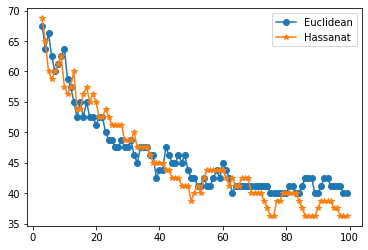

----------------------------------------------IIIT-CFW----------------------------------------------
Best Accuracy using Euclidean: 44.44%, k = 27
Best Accuracy using Hassanat: 42.22%, k = 13
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.75      0.33      0.46         9
           2       0.24      0.62      0.34        16
           3       0.67      0.60      0.63        20
           4       0.52      0.55      0.54        20
           5       0.53      0.45      0.49        20
           6       0.43      0.45      0.44        20
           7       0.56      0.25      0.34        20

    accuracy                           0.44       135
   macro avg       0.50      0.42      0.42       135
weighted avg       0.50      0.44      0.44       135



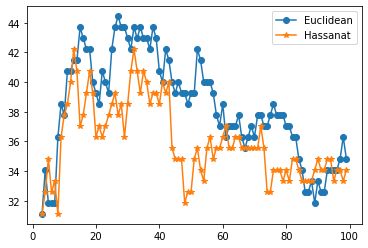

------------------------------------------------Yale------------------------------------------------
Best Accuracy using Euclidean: 84.85%, k = 3
Best Accuracy using Hassanat: 81.82%, k = 4
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       0.60      1.00      0.75         3
           4       1.00      0.50      0.67         2
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         3
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         2

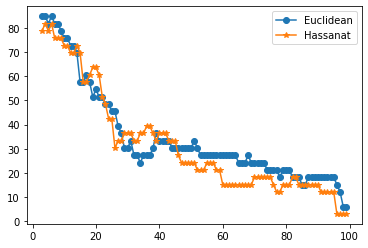

In [52]:
# Use raw data as input to kNN
print("IMFDB".center(100, "-"))
plot_curves(X, y, 8)

print("IIIT-CFW".center(100, "-"))
plot_curves(X_1, y_1, 8)

print("Yale".center(100, "-"))
plot_curves(X_2, y_2, 15)
# plt.savefig("./images/knn_3.png", dpi=150, bbox_inches='tight')

In [53]:
# Using LDA features as input to kNN
print("IMFDB".center(100, "-"))
plot_curves(X, y, 8, lda=True)

print("IIIT-CFW".center(100, "-"))
plot_curves(X_1, y_1, 8, lda=True)

print("Yale".center(100, "-"))
plot_curves(X_2, y_2, 15, lda=True)

-----------------------------------------------IMFDB------------------------------------------------
Best Accuracy using Euclidean: 100.00%, k = 3
Best Accuracy using Hassanat: 100.00%, k = 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

----------------------------------------------IIIT-CFW----------------------------------------------
Best Accuracy using Euclidean: 98.52%, k = 3
Best Accura

### References
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
- https://iq.opengenus.org/face-recognition-using-fisherfaces/
- https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html
- https://docs.opencv.org/4.5.2/da/d60/tutorial_face_main.html
- https://www.bytefish.de/blog/fisherfaces.html
- https://stats.stackexchange.com/a/140579/28666
- https://medium.com/analytics-vidhya/face-detection-and-recognition-using-opencv-and-knn-from-scratch-dcba9b0fd07d